# Possible Solution: Compare baseline model with model with biased features

## Import libraries

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import shap
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
warnings.filterwarnings("ignore")

## Define your working directory

In [51]:
# replace this with yours
os.chdir("/Users/joaomatos/Documents/mit-brown-datathon")

## Load train and test data

In [52]:
data_train = pd.read_csv('data_split/wids_train.csv')
data_test = pd.read_csv('data_split/wids_test.csv')

In [53]:
data_train.shape

(73370, 45)

In [54]:
data_test.shape

(18343, 45)

## Define the outcome column

In [55]:
outcome = ['hospital_death']

In [56]:
y_train = data_train[outcome]
y_test = data_test[outcome]

## Define features to use, for each track

Please comment the cells that do not apply to your track, and run the one that does apply

***To make this model's results comparable with the one from the previous notebook, please make sure to keep the same features, except for the SpO2 and/or Lactate***

In [57]:
# copied from the columns list and removed identifiers or potential data leakage sources
base_features = [
     # patient
     'age',
     'ethnicity',
     'gender',
     'bmi',
     # icu stay
     'icu_admit_source',
     'icu_type',
     # vital signs
     'd1_heartrate_max',
     'd1_heartrate_min',
     'd1_mbp_max',
     'd1_mbp_min',
     'd1_sysbp_max',
     'd1_sysbp_min',
     'd1_diasbp_max',
     'd1_diasbp_min',
     'd1_resprate_max',
     'd1_resprate_min',
     'd1_temp_max',
     'd1_temp_min',
     # labs
     'd1_albumin_min',
     'd1_bilirubin_max',
     'd1_bun_max',
     'd1_calcium_max',
     'd1_calcium_min',
     'd1_creatinine_max',
     'd1_glucose_max',
     'd1_glucose_min',
     'd1_hco3_min',
     'd1_hemaglobin_min',
     'd1_hematocrit_min',
     'd1_inr_max',
     'd1_platelets_min',
     'd1_potassium_max',
     'd1_potassium_min',
     'd1_sodium_max',
     'd1_sodium_min',
     'd1_wbc_max',
]

In [58]:
# baseline models
features_0 = base_features.copy()
features_0.append('d1_spo2_min')
features_0.append('d1_lactate_max')

# track 1: modified SpO2, same train and test
features_1 = base_features.copy()
features_1.append('d1_spo2_min_new')
features_1.append('d1_lactate_max')

# track 1: modified SpO2, different train and test
features_1_train = base_features.copy()
features_1_train.append('d1_spo2_min')
features_1_train.append('d1_lactate_max')

features_1_test = base_features.copy()
features_1_test.append('d1_spo2_min_new')
features_1_test.append('d1_lactate_max')

# track 2: modified lactate, same train and test
features_2 = base_features.copy()
features_2.append('d1_spo2_min')
features_2.append('d1_lactate_max_new')

# track 2: modified lactate, different train and test
features_2_train = base_features.copy()
features_2_train.append('d1_spo2_min')
features_2_train.append('d1_lactate_max')

features_2_test = base_features.copy()
features_2_test.append('d1_spo2_min')
features_2_test.append('d1_lactate_max_new')

# track 3: modified SpO2 and lactate, same train and test
features_3 = base_features.copy()
features_3.append('d1_spo2_min_new')
features_3.append('d1_lactate_max_new')

# track 3: modified SpO2 and lactate, different train and test
features_3_train = base_features.copy()
features_3_train.append('d1_spo2_min')
features_3_train.append('d1_lactate_max')

features_3_test = base_features.copy()
features_3_test.append('d1_spo2_min_new')
features_3_test.append('d1_lactate_max_new')

## Functions

### Sample weigths

In [59]:
def get_sample_weights(y_train):
    
    classes_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(y_train),
        y=y_train.hospital_death
    )
    
    sample_weights = np.ones(y_train.shape[0], dtype = 'float')
    for i, val in enumerate(y_train.hospital_death):
        sample_weights[i] = classes_weights[int(val)]

    return sample_weights

### Metrics

In [60]:
def compute_metrics_long_format(y_true,
                                y_pred_proba,
                                data_test,
                                track,
                                sens_attributes=['ethnicity'],
                               ):
    
    cat_cols = [
        'ethnicity',
    ]
    data_test, _ = my_get_dummies(data_test, data_test, cat_cols)
    
    results = []
    
    for sens_attribute in sens_attributes:

        class_cols = [i for i in data_test.columns if i.startswith(sens_attribute)]
    
        metrics_list = [
            'AUROC',
            'Accuracy',
            'Recall',
            'Precision',
            'F1-score',
        ]
        
        functions_list = [
            roc_auc_score,
            accuracy_score,
            recall_score,
            precision_score,
            f1_score,
        ]
    
        for metric, func in zip(metrics_list, functions_list):
            for e in class_cols:
                y_class_test = y_true.loc[data_test[e] == True]
                y_class_prob = y_pred_proba[data_test[e] == True]
            
                try:
                    value = func(y_class_test, (y_class_prob > 0.5).astype(int)) \
                                               if metric not in ['AUROC'] else func(y_class_test, y_class_prob)
                except:
                    value = np.nan
                
                results.append({
                    # 'Attribute': sens_attribute,
                    'Track': track,
                    'Metric': metric,
                    'Class': e[10:], # a very dirty way of removing the 'ethnicity' prefix
                    'Value': value
                })
    
        # Compute metrics for all classes combined    
        overall_metrics = {}
        for metric, func in zip(metrics_list, functions_list):
            overall_metrics[metric] = func(y_true, (y_pred_proba > 0.5).astype(int)) \
                                               if metric not in ['AUROC'] else func(y_true, y_pred_proba)
    
        for metric, value in overall_metrics.items():
            results.append({
                # 'Attribute': '',
                'Track': track,
                'Metric': metric,
                'Class': 'Overall',
                'Value': value
            })
    
    return pd.DataFrame(results)

### Process Metrics

In [61]:
def process_metrics(metrics_all):
    
    pivoted_metrics = metrics_all.pivot(
        index=['Metric', 'Class'],
        columns=['Track'],
        values=['Value']
    ).droplevel(0,axis=1)

    return pivoted_metrics.sort_index(level=[0,1], axis=1, ascending=True)

### SHAP

In [62]:
def get_explain_plot(fit_model, features): 
    X_train = data_train[features]
    X_test = data_test[features]
    cat_cols = [
        'gender',
        'ethnicity',
        'icu_admit_source',
        'icu_type',
    ]
    X_train, X_test = my_get_dummies(X_train, X_test, cat_cols)
    explainer = shap.Explainer(fit_model)
    shap_values = explainer.shap_values(X_test)  
    shap.summary_plot(shap_values, X_test, plot_size=(8,6)) 

### Model

In [63]:
def my_get_dummies(X_train, X_test, cat_cols):
    # create dummies for categorical variables

    for c in cat_cols:
        X_train = X_train.join(pd.get_dummies(X_train[c], prefix=c))
        X_test = X_test.join(pd.get_dummies(X_test[c], prefix=c))
    
    X_train = X_train.drop(columns=cat_cols)
    X_test = X_test.drop(columns=cat_cols)

    return X_train, X_test

In [64]:
def model_track(metrics_all, features_train, features_test, track):

    X_train = data_train[features_train]
    X_test = data_test[features_test]

    cat_cols = [
        'gender',
        'ethnicity',
        'icu_admit_source',
        'icu_type',
    ]

    X_train, X_test = my_get_dummies(X_train, X_test, cat_cols)
    
    model = XGBClassifier() 
    model.fit(X_train.to_numpy(), y_train, sample_weight=get_sample_weights(y_train))
    y_prob = model.predict_proba(X_test.to_numpy())[:, 1]

    metrics_track = compute_metrics_long_format(
        y_test,
        y_prob,
        data_test,
        track,
        sens_attributes=['ethnicity'],
    )

    return pd.concat([metrics_all, metrics_track], axis=0), model


## Run!

### Train and Test use different feature distribution
(assuming that the SpO2 bias or Lactate are unexpected and not seen in train)

In [65]:
metrics_all = pd.DataFrame()
metrics_all, model_0 = model_track(metrics_all, features_0, features_0, track='[0] Baseline')
metrics_all, model_1 = model_track(metrics_all, features_1_train, features_1_test, track='[1] SpO2')
metrics_all, model_2 = model_track(metrics_all, features_2_train, features_2_test, track='[2] Lactate')
metrics_all, model_3 = model_track(metrics_all, features_3_train, features_3_test, track='[3] SpO2 + Lactate')

process_metrics(metrics_all)


Track                       [0] Baseline  [1] SpO2  [2] Lactate  \
Metric    Class                                                   
AUROC     African American      0.869048  0.847505     0.862516   
          Asian                 0.842355  0.842355     0.842355   
          Caucasian             0.858794  0.858794     0.858794   
          Hispanic              0.841320  0.841320     0.841320   
          Native American       0.951274  0.951274     0.951274   
          Other/Unknown         0.883419  0.883419     0.883419   
          Overall               0.860248  0.857967     0.859554   
Accuracy  African American      0.873418  0.848608     0.874937   
          Asian                 0.847826  0.847826     0.847826   
          Caucasian             0.854067  0.854067     0.854067   
          Hispanic              0.841558  0.841558     0.841558   
          Native American       0.909091  0.909091     0.909091   
          Other/Unknown         0.868757  0.868757     0.868757   
          Overall               0.857112  0.854440     0.857275   
F1-score  African American      0.413146  0.373166     0.401937   
          Asian                 0.339623  0.339623     0.339623   
          Caucasian             0.429444  0.429444     0.429444   
          Hispanic              0.495868  0.495868     0.495868   
          Native American       0.648649  0.648649     0.648649   
          Other/Unknown         0.443350  0.443350     0.443350   
          Overall               0.433297  0.428999     0.432350   
Precision African American      0.316547  0.270517     0.313208   
          Asian                 0.264706  0.264706     0.264706   
          Caucasian             0.324517  0.324517     0.324517   
          Hispanic              0.416667  0.416667     0.416667   
          Native American       0.521739  0.521739     0.521739   
          Other/Unknown         0.328467  0.328467     0.328467   
          Overall               0.329822  0.324701     0.329587   
Recall    African American      0.594595  0.601351     0.560811   
          Asian                 0.473684  0.473684     0.473684   
          Caucasian             0.634647  0.634647     0.634647   
          Hispanic              0.612245  0.612245     0.612245   
          Native American       0.857143  0.857143     0.857143   
          Other/Unknown         0.681818  0.681818     0.681818   
          Overall               0.631380  0.632010     0.628229   

Track                       [3] SpO2 + Lactate  
Metric    Class                                 
AUROC     African American            0.838381  
          Asian                       0.842355  
          Caucasian                   0.858794  
          Hispanic                    0.841320  
          Native American             0.951274  
          Other/Unknown               0.883419  
          Overall                     0.857154  
Accuracy  African American            0.842025  
          Asian                       0.847826  
          Caucasian                   0.854067  
          Hispanic                    0.841558  
          Native American             0.909091  
          Other/Unknown               0.868757  
          Overall                     0.853732  
F1-score  African American            0.363265  
          Asian                       0.339623  
          Caucasian                   0.429444  
          Hispanic                    0.495868  
          Native American             0.648649  
          Other/Unknown               0.443350  
          Overall                     0.427810  
Precision African American            0.260234  
          Asian                       0.264706  
          Caucasian                   0.324517  
          Hispanic                    0.416667  
          Native American             0.521739  
          Other/Unknown               0.328467  
          Overall                     0.323340  
Recall    African American            0.601351  
 

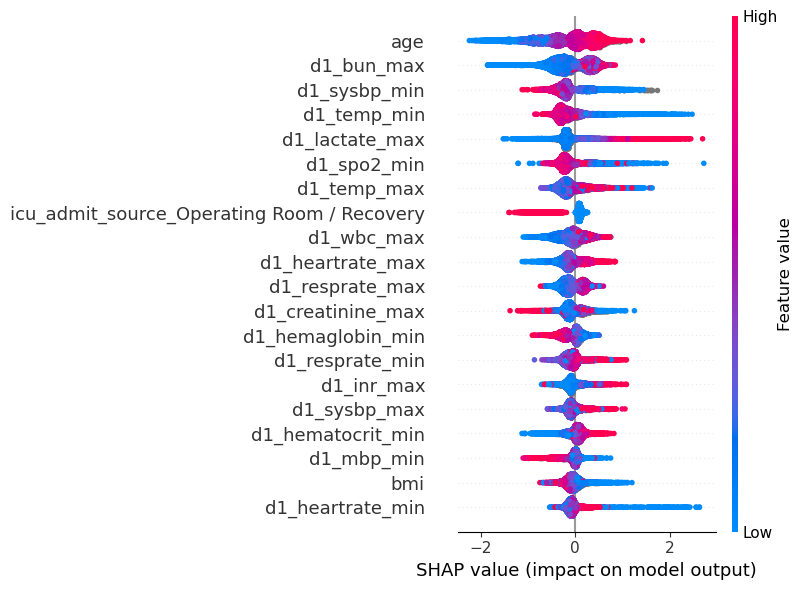

In [66]:
get_explain_plot(model_0, features_0)

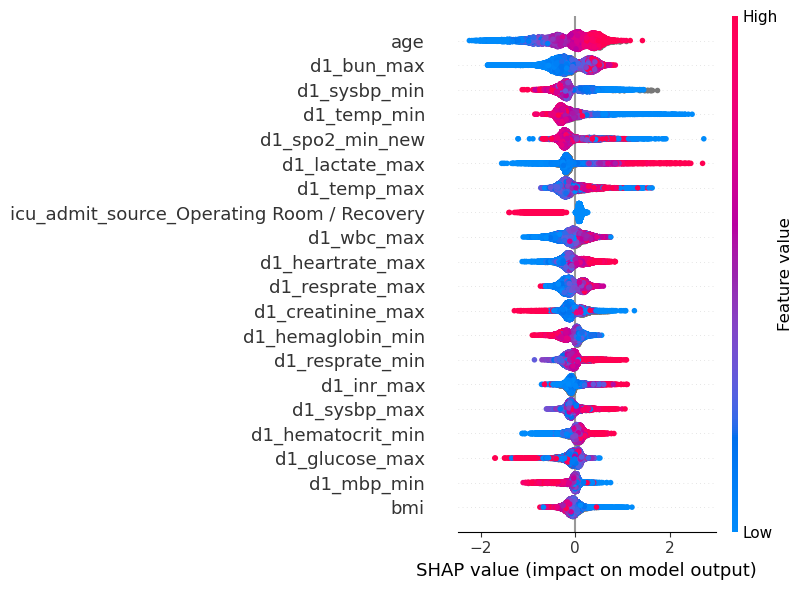

In [67]:
get_explain_plot(model_1, features_1_test)

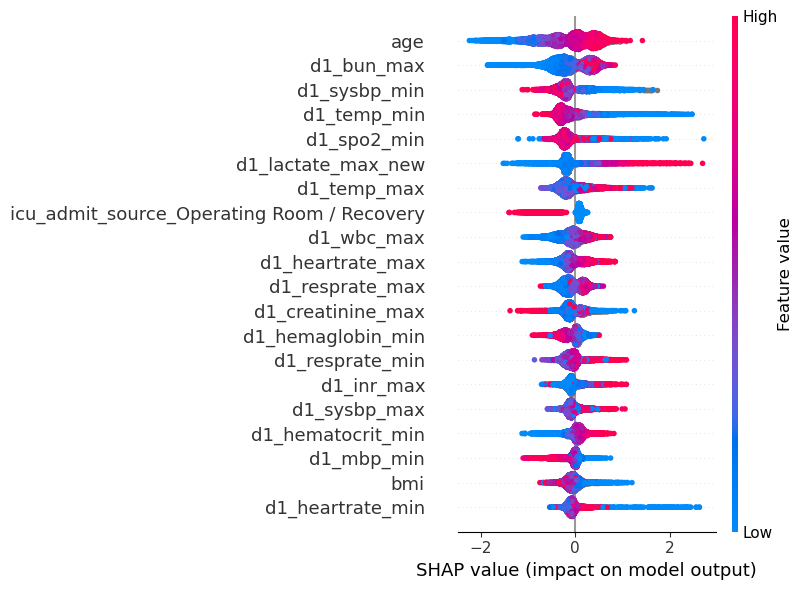

In [68]:
get_explain_plot(model_2, features_2_test)

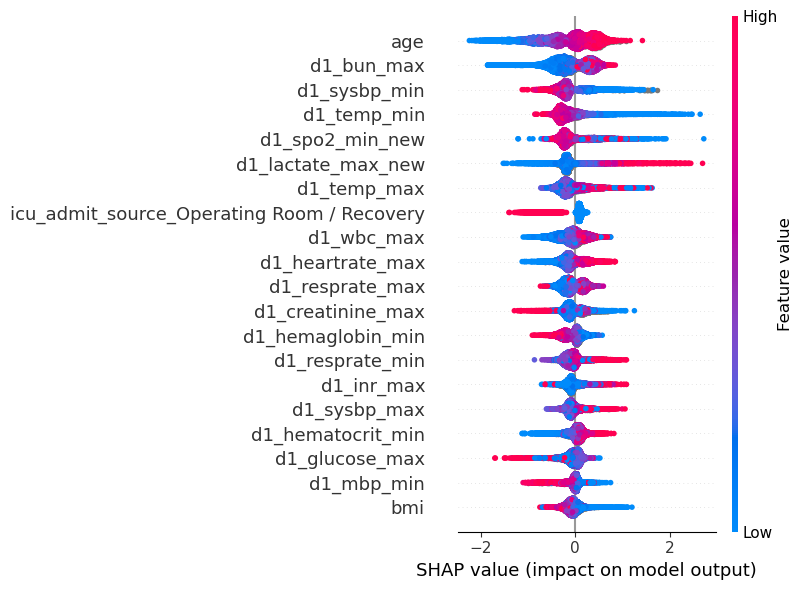

In [69]:
get_explain_plot(model_3, features_3_test)

### Train and Test have consistent distributions
(assuming that the flaws have been seen in train and the model can learn them)

In [70]:
metrics_all_same = pd.DataFrame()
metrics_all_same, model_0 = model_track(metrics_all_same, features_0, features_0, track='[0] Baseline')
metrics_all_same, model_1 = model_track(metrics_all_same, features_1, features_1, track='[1] SpO2')
metrics_all_same, model_2 = model_track(metrics_all_same, features_2, features_2, track='[2] Lactate')
metrics_all_same, model_3 = model_track(metrics_all_same, features_3, features_3, track='[3] SpO2 + Lactate')
process_metrics(metrics_all_same)

Track                       [0] Baseline  [1] SpO2  [2] Lactate  \
Metric    Class                                                   
AUROC     African American      0.869048  0.849510     0.856962   
          Asian                 0.842355  0.861811     0.842105   
          Caucasian             0.858794  0.862479     0.861171   
          Hispanic              0.841320  0.844813     0.837874   
          Native American       0.951274  0.941307     0.910299   
          Other/Unknown         0.883419  0.866972     0.875548   
          Overall               0.860248  0.860691     0.859651   
Accuracy  African American      0.873418  0.877975     0.870380   
          Asian                 0.847826  0.847826     0.826087   
          Caucasian             0.854067  0.855844     0.854636   
          Hispanic              0.841558  0.841558     0.837662   
          Native American       0.909091  0.902098     0.902098   
          Other/Unknown         0.868757  0.866434     0.872242   
          Overall               0.857112  0.858856     0.856676   
F1-score  African American      0.413146  0.422062     0.420814   
          Asian                 0.339623  0.313725     0.310345   
          Caucasian             0.429444  0.432448     0.431351   
          Hispanic              0.495868  0.483051     0.485597   
          Native American       0.648649  0.631579     0.588235   
          Other/Unknown         0.443350  0.416244     0.438776   
          Overall               0.433297  0.434346     0.432549   
Precision African American      0.316547  0.327138     0.316327   
          Asian                 0.264706  0.250000     0.230769   
          Caucasian             0.324517  0.327959     0.326050   
          Hispanic              0.416667  0.413043     0.406897   
          Native American       0.521739  0.500000     0.500000   
          Other/Unknown         0.328467  0.312977     0.330769   
          Overall               0.329822  0.332441     0.328956   
Recall    African American      0.594595  0.594595     0.628378   
          Asian                 0.473684  0.421053     0.473684   
          Caucasian             0.634647  0.634647     0.637110   
          Hispanic              0.612245  0.581633     0.602041   
          Native American       0.857143  0.857143     0.714286   
          Other/Unknown         0.681818  0.621212     0.651515   
          Overall               0.631380  0.626339     0.631380   

Track                       [3] SpO2 + Lactate  
Metric    Class                                 
AUROC     African American            0.845933  
          Asian                       0.878024  
          Caucasian                   0.858851  
          Hispanic                    0.829568  
          Native American             0.965116  
          Other/Unknown               0.861654  
          Overall                     0.856695  
Accuracy  African American            0.871899  
          Asian                       0.860870  
          Caucasian                   0.853712  
          Hispanic                    0.836364  
          Native American             0.902098  
          Other/Unknown               0.866434  
          Overall                     0.856512  
F1-score  African American            0.407494  
          Asian                       0.428571  
          Caucasian                   0.432000  
          Hispanic                    0.487805  
          Native American             0.611111  
          Other/Unknown               0.385027  
          Overall                     0.432514  
Precision African American            0.311828  
          Asian                       0.324324  
          Caucasian                   0.325301  
          Hispanic                    0.405405  
          Native American             0.500000  
          Other/Unknown               0.297521  
          Overall                     0.328745  
Recall    African American            0.587838  
 

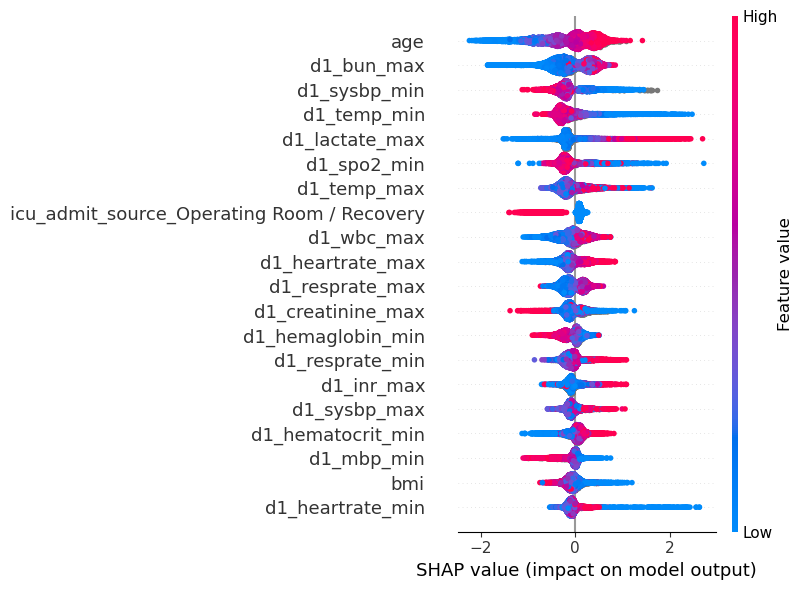

In [71]:
get_explain_plot(model_0, features_0)

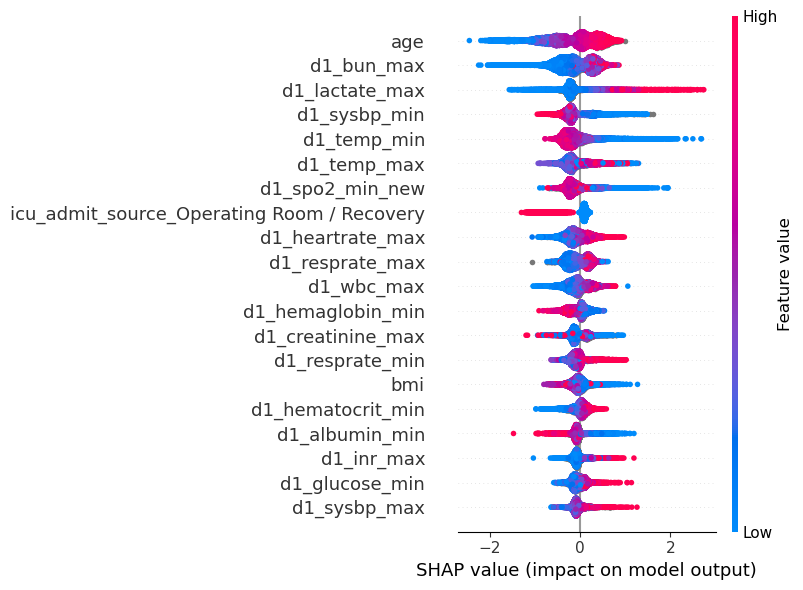

In [72]:
get_explain_plot(model_1, features_1)

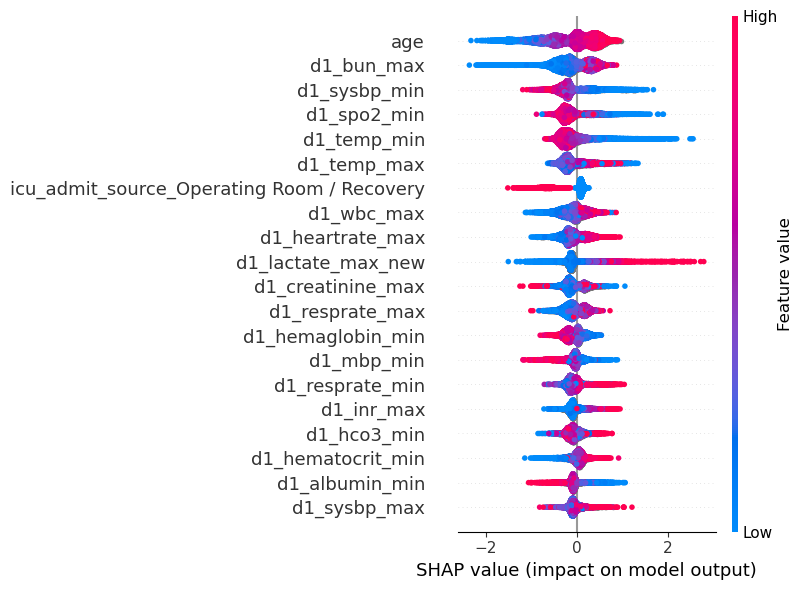

In [73]:
get_explain_plot(model_2, features_2)

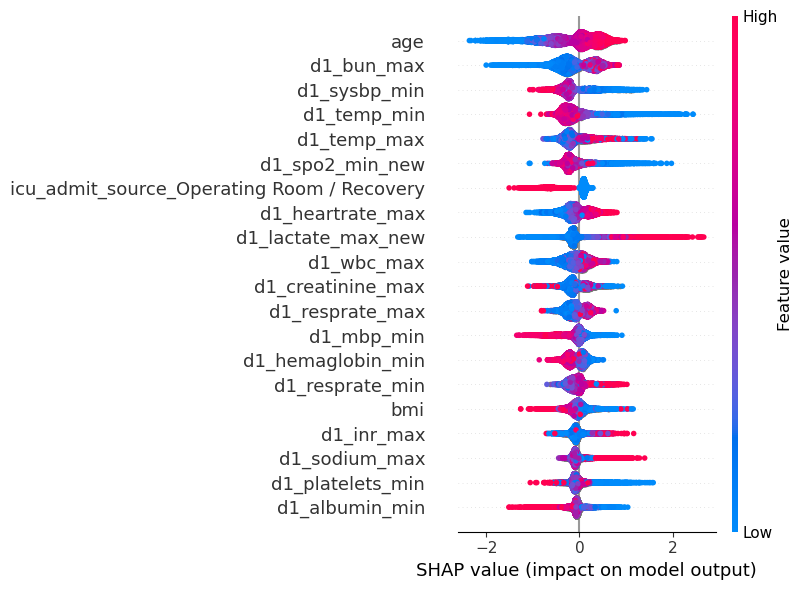

In [74]:
get_explain_plot(model_3, features_3)